In [2]:
# Importing Libraries
import tensorflow as tf
import os
import numpy as np
import sys
import random
import cv2
import glob
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

In [2]:
seed = 42
np.random.seed = seed

In [3]:
# Input Image Dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [4]:
# Processing training datasets
processing = False
X_train = []
Y_train = []
count = 0
if processing:
    print('Resizing training images')
    for filename in glob.glob('dataset/train/*.jpg'):
        img = cv2.imread(filename)
        img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
        height, width, layers = img.shape
        
        if count == 0:
            print(height, width, layers)
            print(type(img))
        count += 1
        size = (width,height)
        X_train.append(img)
    print('Training Data resizing Finished')
    
    
    print('Resizing training masks')
    count = 0
    for filename in glob.glob('dataset/train_masks/*.gif'):
        img = imread(filename)
        img = resize(img, (IMG_HEIGHT, IMG_HEIGHT), mode='constant', preserve_range=True)
        count += 1
        Y_train.append(img)
        print(count)
    print('Training Mask resizing Finished')

    
    X_train = np.array(X_train)
    print(type(X_train))
    np.save('NPY files/trainingNPYfiles/TrainingDataCar', X_train)
    
    Y_train = np.array(Y_train)
    print(type(Y_train))
    np.save('NPY files/trainingNPYfiles/MasksCar', Y_train)

else:
    print('Input image already processed. Modify processing parameter to False to process input images again.')
    
    

Input image already processed. Modify processing parameter to False to process input images again.


5088


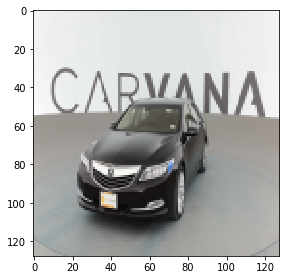

(5088, 128, 128, 3)
5088


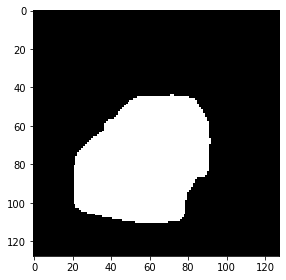

(5088, 128, 128, 3)


In [5]:
X_train = np.load('NPY files/trainingNPYfiles/TrainingDataCar.npy')
print(len(X_train))
imshow(X_train[1])
plt.show()
print(X_train.shape)

Y_train = np.load('NPY files/trainingNPYfiles/MasksCar.npy')
print(len(Y_train))
imshow(np.squeeze(Y_train[1]))
plt.show()
print(X_train.shape)

In [6]:
# Y_train1 = np.zeros((len(Y_train), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

# for i in range(len(Y_train)):
#     Y_train1[i] = np.expand_dims(resize(Y_train[i], (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
#     print(i)

# np.save('NPY files/trainingNPYfiles/MasksCar', Y_train1)
# imshow(np.squeeze(Y_train1[1]))
# plt.show()

In [7]:
# Processing testing datasets
processTest = False
count = 0
X_test = []
if processTest:
    print('Resizing testing images')

    for filename in glob.glob('dataset/test/*.jpg'):
        img = cv2.imread(filename)
        img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
        height, width, layers = img.shape
        
        if count == 0:
            print(height, width, layers)
            print(type(img))
        count += 1
        size = (width,height)
        X_test.append(img)
        print(count)
    print('Testing Data resizing Finished')
    
    # This is done to avoid redundant processing
    X_test = np.array(X_test)
    print(type(X_test))
    np.save('NPY files/testingNPYfiles/TestingDataCar', X_test)
else:
    print('Testing images already processed. Modify processTest parameter to False to process testing images again.')

Testing images already processed. Modify processTest parameter to False to process testing images again.


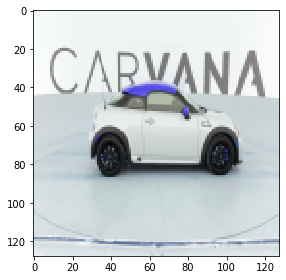

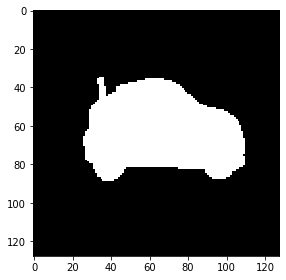

In [8]:
# Validating
X_train = np.load('NPY files/trainingNPYfiles/TrainingDataCar.npy')
imageX = random.randint(0, len(X_train))
imshow(X_train[imageX])
plt.show()

Y_train = np.load('NPY files/trainingNPYfiles/MasksCar.npy')
imshow(np.squeeze(Y_train[imageX]))
plt.show()

In [9]:
# Building the U-net model
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)) # Defining the input layer
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs) # Converting input pixels to floating values

c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1) # To prevent neural net from over fitting
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2) # To prevent neural net from over fitting
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3) # To prevent neural net from over fitting
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4) # To prevent neural net from over fitting
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5) # To prevent neural net from over fitting
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Decoding the layers
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6) # To prevent neural net from over fitting
c6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7) # To prevent neural net from over fitting
c7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8) # To prevent neural net from over fitting
c8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9) # To prevent neural net from over fitting
c9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [10]:
# Model Checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
             tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [11]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100,callbacks=callbacks)

Train on 4579 samples, validate on 509 samples
Epoch 1/100
4579/4579 [==============================] - 65s 14ms/sample - loss: 0.1017 - accuracy: 0.9572 - val_loss: 0.0644 - val_accuracy: 0.9744
Epoch 2/100
4579/4579 [==============================] - 49s 11ms/sample - loss: 0.0321 - accuracy: 0.9871 - val_loss: 0.0361 - val_accuracy: 0.9862
Epoch 3/100
4579/4579 [==============================] - 47s 10ms/sample - loss: 0.0230 - accuracy: 0.9909 - val_loss: 0.0238 - val_accuracy: 0.9911
Epoch 4/100
4579/4579 [==============================] - 49s 11ms/sample - loss: 0.0190 - accuracy: 0.9925 - val_loss: 0.0237 - val_accuracy: 0.9914
Epoch 5/100
4579/4579 [==============================] - 47s 10ms/sample - loss: 0.0172 - accuracy: 0.9933 - val_loss: 0.0196 - val_accuracy: 0.9930
Epoch 6/100
4579/4579 [==============================] - 47s 10ms/sample - loss: 0.0156 - accuracy: 0.9939 - val_loss: 0.0171 - val_accuracy: 0.9937
Epoch 7/100
4579/4579 [==============================] - 47

In [12]:
X_test = np.load('NPY files/testingNPYfiles/TestingDataCar.npy')

In [13]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test[0:int(len(X_test)/10)], verbose=1)
# preds_test1 = model.predict(X_test[int(len(X_test)/4):int(len(X_test)/2)], verbose=1)
# preds_test2 = model.predict(X_test[int(len(X_test)/2):], verbose=1)
# preds_test3 = model.predict(X_test[0:int(len(X_test)/4)], verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

10006/10006 [==============================] - 31s 3ms/sample


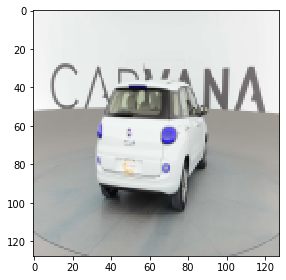

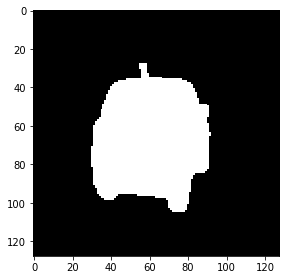

D:\anaconda3\envs\tensorflow\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


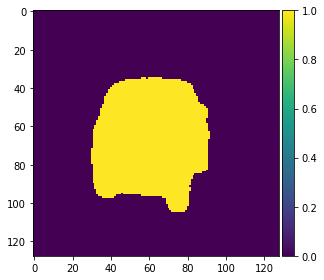

In [14]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

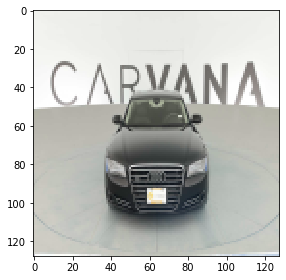

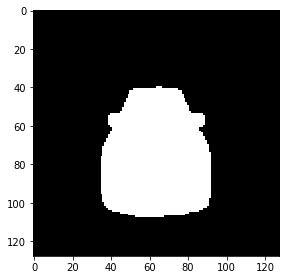

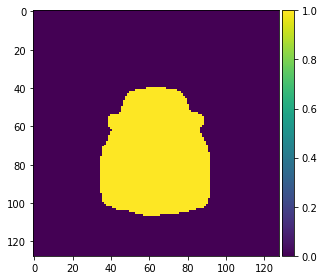

509


In [15]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
print(len(preds_val_t))

In [1]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

NameError: name 'random' is not defined

In [17]:
# Making a video out of input test images
make_video = False

if make_video:
      # This is done to individually compare the test output images with the test input images
#     for i in range(len(X_test)):
#         imshow(X_test[i])
#         plt.savefig('inputTestImages/input' + str(i) + '.jpg')
#         plt.show()
    
    out = cv2.VideoWriter('Output/video/inputVideo.avi',cv2.VideoWriter_fourcc(*'DIVX'), 0.8, (128, 128))

    for i in range(len(X_test)):
        out.write(X_test[i])
    out.release()

In [18]:
# Making a video out of output test images
make_video = False

if make_video:
    # Saving all the images in outputImages folder
    for i in range(len(preds_test_t)):
            imshow(np.squeeze(preds_test_t[i]))
            plt.savefig('Output/outputImages/output' + str(i) + '.jpg')
            plt.show()

    img_array = []
    for filename in glob.glob('Output/outputImages/*.jpg'):
        img = cv2.imread(filename)
        height, width, layers = img.shape
#         print(height, width, layers)
        size = (width,height)
        img_array.append(img)


    out = cv2.VideoWriter('Output/video/SegmentedOutput.avi',cv2.VideoWriter_fourcc(*'DIVX'), 0.8, (432,288))

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [ ]:
!tensorboard --logdir=logs/ --host localhost --port 8098